In [1]:
from pathlib import Path

import mne
import nltk
import numpy as np
import pandas as pd
import re
import scipy.io
from tqdm.notebook import tqdm

# Transformers prep
import os
os.environ["TRANSFORMERS_CACHE"] = str((Path(".") / "transformers_cache").resolve())
import transformers
import torch
RECOMPUTE_SURPRISALS = False

DATA_DIR = Path("/om/data/public/broderick2018/Natural Speech")
EEG_DIR = DATA_DIR / "EEG"
STIM_DIR = DATA_DIR / "Stimuli" / "Text"
ENVELOPE_DIR = DATA_DIR / "Stimuli" / "Envelopes"

FULL_TEXT_PATH = Path("data/texts/old-man-and-the-sea.txt")

SURPRISALS_DIR = Path("data/surprisals")
# SURPRISALS_HF_MODEL = "hf-internal-testing/tiny-xlm-roberta" #"gpt2"
SURPRISALS_HF_MODEL = "EleutherAI/gpt-neo-125M"
SURPRISALS_CHECKPOINT_PATH = SURPRISALS_DIR / ("surprisals_" + SURPRISALS_HF_MODEL.replace("/", "-") + ".csv")

In [2]:
# Metadata for Broderick et al 2018
NUM_DATA_CHANNELS = 128
# 2 mastoid channels
NUM_REFERENCE_CHANNELS = 2
NUM_CHANNELS = NUM_DATA_CHANNELS + NUM_REFERENCE_CHANNELS
SAMPLE_RATE = 128

data_channels = [f"V{i + 1}" for i in range(NUM_DATA_CHANNELS)]
reference_channels = [f"M{i + 1}" for i in range(NUM_REFERENCE_CHANNELS)]
channel_names = data_channels + reference_channels

# EEG Processing parameters
EPOCH_TMIN = -0.2
EPOCH_TMAX = 0.5

# EEG band-pass filter parameters
FILTER_LOW = 1.
FILTER_HIGH = 8.

In [3]:
%load_ext autoreload
%autoreload 2
import utils

Reference: https://mne.tools/stable/auto_tutorials/evoked/30_eeg_erp.html#sphx-glr-auto-tutorials-evoked-30-eeg-erp-py

## TODO

- other preprocessing which might be necessary
  - ICA
  - eye movement artifact removal

## Glossary

- preprocessing steps
  - detrending: Subtract least-square linear fit from time series, cf. https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.detrend.html
  - baselining: Subtract per-channel mean from signal
  - decimating: Data subsampling (over time)

## Load stimuli

In [4]:
stim_paths = list(STIM_DIR.glob("*.mat"))
stim_df = pd.concat([utils.load_stimuli(path) for path in stim_paths],
                    keys=[int(p.stem.replace("Run", "")) for p in stim_paths],
                    names=["item", "content_word_idx"]).sort_index()
stim_df

word  onset_time  offset_time
item content_word_idx                                    
1    0                       OLD        1.12         1.41
     1                       MAN        1.41         1.79
     2                    FISHED        2.08         2.41
     3                     ALONE        2.41         2.77
     4                     SKIFF        2.95         3.41
...                          ...         ...          ...
20   250               NECESSARY      184.43       184.93
     251                    FREE      185.06       185.42
     252                   UNTIE      185.56       186.00
     253                 VARIOUS      186.11       186.57
     254                   LINES      186.57       187.07

[5459 rows x 3 columns]

### Align stimuli with original text and surprisals

We will simultaneously run this alignment, accounting for differences in tokenization and in words missing in the stimuli (which only contain "content words").

In [5]:
sentences = nltk.tokenize.PunktSentenceTokenizer().tokenize(FULL_TEXT_PATH.open().read())
sentences = [nltk.tokenize.RegexpTokenizer("[\w']+|[^\w\s]+").tokenize(sent) for sent in sentences]
tokens_flat = [tok for sent in sentences for tok in sent]

In [6]:
## Align stimulus rows with full text content, in preparation
## for re-inserting non-content words.

punct_re = re.compile(r"[^A-Za-z]")

stop = False

tok_cursor = 0
surp_cursor = 0

tok_el = tokens_flat[tok_cursor]
# surp_el = surprisals_df.iloc[surp_cursor]

# For each element in surp_df, record the index of the corresponding element
# in the token sequence or surprisal df.
tok_pos, surp_pos = [], []
for item, rows in tqdm(stim_df.groupby("item")):
    if stop: break
        
    # print("==========", item)
    for idx, row in rows.iterrows():
        # print(row.word, "::")
        
        # Track how many elements in a reference we have skipped. If this is excessive,
        # we'll quit rather than looping infinitely.
        skip_count = 0
        if stop: break
        
        # Find corresponding token in text and append to `tok_pos`.
        try:
            tok_el = punct_re.sub("", tok_el)
            while not tok_el.startswith(row.word.lower()):
                tok_cursor += 1
                skip_count += 1
                if skip_count > 20:
                    stop = True
                    break
                
                tok_el = utils.strip_accents(tokens_flat[tok_cursor].lower())
                # print("\t//", element)
                
            # print("\tMatch", row.word, element)
            tok_pos.append(tok_cursor)

            # If we matched only a subset of the token, then cut off what we
            # matched and proceed.
            if tok_el != row.word.lower():
                tok_el = tok_el[len(row.word):]
        except IndexError:
            print("iex", row, tok_cursor, tok_el)
            stop = True
            break
        
#         surp_word = punct_re.sub("", surp_el.token)
#         while not surp_el.token == row.word.lower():
#             surp_cursor += 1
#             skip_count += 1
#             if skip_count > 20:
#                 stop = True
#                 break
                
#             surp_el = surprisals_df.iloc[surp_cursor]
            
#         print("\tSurp match", row.word, surp_cursor, surp_el.token)
#         surp_pos.append(surp_cursor)
        
        # DEV
        # if tok_cursor > 50:
        #     stop = True
            
stim_df["tok_pos"] = tok_pos

  0%|          | 0/20 [00:00<?, ?it/s]

In [7]:
if RECOMPUTE_SURPRISALS:
    hf_tokenizer = transformers.AutoTokenizer.from_pretrained(SURPRISALS_HF_MODEL)
    hf_model = transformers.AutoModelForCausalLM.from_pretrained(SURPRISALS_HF_MODEL,
                                                                 add_cross_attention=True, is_decoder=True)

    tokenized = hf_tokenizer.batch_encode_plus(
        [" ".join(sentence) for sentence in sentences],
        add_special_tokens=True, return_offsets_mapping=True)

    global_tok_cursor = 0

    # Each element is of form (global_text_tok_idx, sent_idx, text_tok_idx, tok_idx, surprisal)
    # `global_text_tok_idx` is an index into `tokens_flat`
    # `sent_idx` is an index into `sentences`
    # `text_tok_idx` is an index into `sentences[sent_idx]`
    surp_mapping = []
    for sent_idx, sentence in enumerate(tqdm(sentences)):
        sent_tokens = torch.tensor(tokenized["input_ids"][sent_idx]).unsqueeze(0)

        # Run batches of decoding, accounting for limited sequence input size
        max_len = 512
        past = None
        input_ids = sent_tokens.clone()
        surprisal_outputs = []
        while True:
            with torch.no_grad():
                outputs_b = hf_model(
                    input_ids=input_ids[:, :max_len],
                    past_key_values=past,
                    return_dict=True)

            # at most max_len * vocab_size
            surprisal_outputs.append(-outputs_b["logits"].log_softmax(dim=2).squeeze(0).numpy())

            past = outputs_b["past_key_values"]

            if input_ids.shape[1] <= max_len:
                # Done.
                break
            else:
                input_ids = input_ids[:, max_len:]

        # T * vocab_size
        all_surprisals = np.concatenate(surprisal_outputs, axis=0)

        # get surprisals of expected words
        surps_shifted = all_surprisals[:-1, :]
        sent_tokens_shifted = sent_tokens.squeeze()[1:]
        token_surps = surps_shifted[range(surps_shifted.shape[0]), sent_tokens_shifted]

        word_ids = tokenized.word_ids(sent_idx)
        for tok_id, surp in enumerate(token_surps):
            if word_ids[tok_id] is None:
                continue
            surp_mapping.append((global_tok_cursor + word_ids[tok_id],
                                 sent_idx, word_ids[tok_id], tok_id, surp))

        global_tok_cursor += len(sentence)

    surp_mapping = pd.DataFrame(surp_mapping, columns=["global_text_tok_idx", "sent_idx",
                                                       "text_tok_idx", "tok_idx", "surprisal"])
    
    surp_mapping.to_csv(SURPRISALS_CHECKPOINT_PATH)
else:
    surp_mapping = pd.read_csv(SURPRISALS_CHECKPOINT_PATH)

### Merge into `stim_df`

In [8]:
surp_mapping["token"] = surp_mapping.global_text_tok_idx.map(dict(enumerate(tokens_flat)))

In [9]:
surp_mapping.groupby(["global_text_tok_idx", "token"]).surprisal.sum()

global_text_tok_idx  token  
0                    He         2.660097
1                    was        3.965186
2                    an         3.409394
3                    old        1.007797
4                    man        2.824772
                                  ...   
12814                and        8.506883
12815                untie      3.200993
12816                the        7.338224
12817                various    6.563997
12818                lines      8.991981
Name: surprisal, Length: 12111, dtype: float64

In [10]:
stim_df = pd.merge(stim_df, surp_mapping.groupby(["global_text_tok_idx"]).surprisal.sum(),
                   how="left", left_on="tok_pos", right_index=True)

### Compute EEG sample points

In [11]:
# Compute the nearest following sample for each word onset.
stim_df["sample_id"] = np.ceil(stim_df.onset_time * SAMPLE_RATE).astype(int)

## Load envelope data

In [12]:
# TODO why don't envelope seq and data seq match in shape ?
# want to eventually insert envelope as an extra channel in the `Raw`
# so that it gets transformed correctly during epoching

## Load EEG data

We'll manually create MNE representations from the raw data given in the dataset.

### Demo with one subject

#### Load raw EEG

In [16]:
eeg_paths = list(EEG_DIR.glob("**/Subject1_*.mat"))
subj1_eeg = utils.load_eeg(eeg_paths, data_channels, reference_channels,
                           sample_rate=SAMPLE_RATE,
                           filter_low=FILTER_LOW, filter_high=FILTER_HIGH)

# stim_df = pd.concat([load_stimuli(path) for path in stim_paths],
#                     keys=[int(p.stem.replace("Run", "")) for p in stim_paths],
#                     names=["item"]).sort_index()
# stim_df

Creating RawArray with float64 data, n_channels=130, n_times=497827
    Range : 0 ... 497826 =      0.000 ...  3889.266 secs
Ready.
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 8 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 8.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 9.00 Hz)
- Filter length: 423 samples (3.305 sec)



#### Convert stim info to events

The substantive mapping here is to map from continuous time within run (what is represented in `stim_df`) onto the nearest EEG sample. Yikes.

In [17]:
events_arr = []
EVENT_ID_WORD = 2
for i, run_offset in enumerate(subj1_eeg[1]):
    word_offsets = stim_df.loc[i + 1].sample_id + run_offset
    
    events_arr.append(np.stack([
        word_offsets,
        np.zeros_like(word_offsets),
        EVENT_ID_WORD * np.ones_like(word_offsets)
    ], axis=1))
events_seq = np.concatenate(events_arr)

#### Epoching

https://mne.tools/dev/generated/mne.Epochs.html

> When accessing data, Epochs are detrended, baseline-corrected, and decimated, then projectors are (optionally) applied.

TODO Q: Why is baselining necessary if detrending linear fit includes a constant bias?

In [26]:
epochs = mne.Epochs(subj1_eeg[0], events_seq,
                    preload=True, # load epochs into memory
                    tmin=EPOCH_TMIN, tmax=EPOCH_TMAX)

Not setting metadata
Not setting metadata
5459 matching events found
Setting baseline interval to [-0.203125, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 5459 events and 91 original time points ...
0 bad epochs dropped


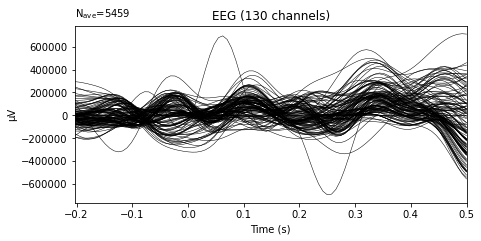

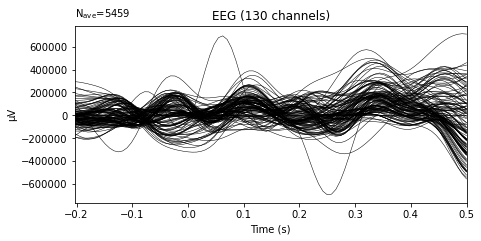

In [27]:
epochs.average().plot()

#### Simple N400 check

In [28]:
WINDOW = (0.4, 0.45)

# TODO don't enable baselining between items
baselined_df = epochs.copy().apply_baseline().crop(0.4, 0.45).to_data_frame(index=["condition", "epoch", "time"])

Applying baseline correction (mode: mean)


In [29]:
# Merge in item information
baselined_df = pd.merge(baselined_df.reset_index(), stim_df.reset_index()[["content_word_idx", "item"]],
                        left_on="epoch", right_on="content_word_idx")
baselined_df.head()

,condition,epoch,time,V1,V2,V3,V4,V5,V6,V7,...,V123,V124,V125,V126,V127,V128,M1,M2,content_word_idx,item
0,2,0,398,2.373069e+06,2.504639e+06,2.917046e+06,1.406300e+06,-1.158176e+06,2.616693e+06,3.680079e+06,...,1.963807e+06,-357451.245198,1.232585e+07,4.114351e+06,1.368228e+07,1.417734e+07,-18508.665677,18508.665677,0,1
1,2,0,398,2.373069e+06,2.504639e+06,2.917046e+06,1.406300e+06,-1.158176e+06,2.616693e+06,3.680079e+06,...,1.963807e+06,-357451.245198,1.232585e+07,4.114351e+06,1.368228e+07,1.417734e+07,-18508.665677,18508.665677,0,2
2,2,0,398,2.373069e+06,2.504639e+06,2.917046e+06,1.406300e+06,-1.158176e+06,2.616693e+06,3.680079e+06,...,1.963807e+06,-357451.245198,1.232585e+07,4.114351e+06,1.368228e+07,1.417734e+07,-18508.665677,18508.665677,0,3
3,2,0,398,2.373069e+06,2.504639e+06,2.917046e+06,1.406300e+06,-1.158176e+06,2.616693e+06,3.680079e+06,...,1.963807e+06,-357451.245198,1.232585e+07,4.114351e+06,1.368228e+07,1.417734e+07,-18508.665677,18508.665677,0,4
4,2,0,398,2.373069e+06,2.504639e+06,2.917046e+06,1.406300e+06,-1.158176e+06,2.616693e+06,3.680079e+06,...,1.963807e+06,-357451.245198,1.232585e+07,4.114351e+06,1.368228e+07,1.417734e+07,-18508.665677,18508.665677,0,5


In [30]:
merged_df = pd.concat([stim_df.reset_index(),
                       baselined_df.loc[:, baselined_df.columns != "item"].groupby(["condition", "epoch"]).mean().reset_index()],
                      axis=1)
merged_df

,item,content_word_idx,word,onset_time,offset_time,tok_pos,surprisal,sample_id,condition,epoch,...,V122,V123,V124,V125,V126,V127,V128,M1,M2,content_word_idx
0,1,0,OLD,1.12,1.41,3,1.007797,144,2,0.0,...,-3.559334e+06,1.044086e+06,-7.217937e+05,1.005386e+07,2.807259e+05,6.409489e+06,7.821081e+06,10532.266141,-10532.266141,0.0
1,1,1,MAN,1.41,1.79,4,2.824772,181,2,1.0,...,-4.188196e+06,-6.281302e+06,-1.340899e+06,-3.085431e+05,-5.662782e+06,-5.324589e+06,-8.681236e+06,-26783.024217,26783.024217,1.0
2,1,2,FISHED,2.08,2.41,6,9.653991,267,2,2.0,...,5.338017e+05,1.720820e+06,-9.350176e+05,-1.462324e+06,-1.115593e+07,3.288450e+04,-9.247362e+06,-10167.812850,10167.812850,2.0
3,1,3,ALONE,2.41,2.77,7,2.077590,309,2,3.0,...,1.841785e+06,9.470537e+05,2.122385e+06,-6.102581e+05,-2.730097e+06,2.641523e+06,6.990222e+06,42516.523293,-42516.523293,3.0
4,1,4,SKIFF,2.95,3.41,10,3.006370,378,2,4.0,...,-6.453930e+05,-1.849705e+06,-1.458423e+06,-1.622394e+06,5.590259e+05,-3.042161e+06,-5.642890e+06,53226.615929,-53226.615929,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5454,20,250,NECESSARY,184.43,184.93,12811,0.505702,23608,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5455,20,251,FREE,185.06,185.42,12813,5.136990,23688,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5456,20,252,UNTIE,185.56,186.00,12815,3.200993,23752,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5457,20,253,VARIOUS,186.11,186.57,12817,6.563997,23823,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [31]:
# Dummy corr check: correlation between word length and 400ms baselined response

id_vars = ["word", "surprisal", "epoch", "item"]
electrode_corrs = merged_df[id_vars + data_channels].melt(id_vars=id_vars, var_name="electrode") \
    .dropna() \
    .groupby("electrode").apply(lambda xs: np.corrcoef(xs.surprisal, xs.value)[0, 1])
electrode_corrs.sort_values().tail(20)

electrode
V61    0.107941
V35    0.108260
V51    0.108487
V58    0.109053
V90    0.109882
V56    0.110674
V53    0.114493
V62    0.114629
V59    0.114919
V60    0.115432
V63    0.115648
V55    0.119055
V64    0.119818
V34    0.121062
V54    0.123691
V49    0.123996
V52    0.125950
V33    0.126426
V50    0.128663
V4     0.133299
dtype: float64

<AxesSubplot:ylabel='Frequency'>

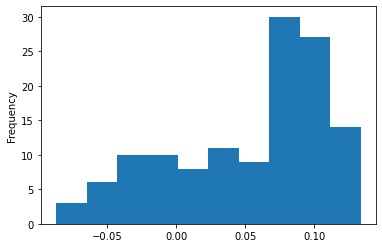

In [32]:
electrode_corrs.plot.hist()